In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate as integrate
from matplotlib import gridspec
import scipy.signal
import healpy as hp
#import Corrfunc
from numba import jit
from scipy.stats import poisson, erlang
from scipy import interpolate
from os import urandom
import struct
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib import gridspec
import seaborn as sns
from datetime import datetime
from scipy.special import factorial
from scipy.signal import savgol_filter
from scipy import integrate as integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy import interpolate
from scipy.stats import norm
import math
import copy

from sklearn.neighbors import BallTree



In [3]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc("text", usetex=True)
plt.rc("font", size=22)

In [4]:
def cdf_vol_knn(vol):
    '''
    Computes an interpolating function to evaluate CDF 
    at a given radius.
    
    Parameters
    ----------
    
    vol: float[:,:]
        List of nearest neighbor distances for each kNN.
        vol.shape[1] should be # of kNN
    
    Returns
    -------
    
    cdf: scipy interpolating function for each kNN
    '''
    
    cdf = []
    n = vol.shape[0]
    l = vol.shape[1]
    gof = ((np.arange(0, n) + 1) / (n*1.0))
    for c in range(l):
        ind = np.argsort(vol[:, c])
        s_vol= vol[ind, c]
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', 
                                        bounds_error=False))
    return cdf

def compute_cdf(pos, kNN, nrandoms, bins):
    '''
    Computes the CDF of nn distances of 
    data points from a set of space-filling
    randoms.
    
     
    Parameters
    ----------
    
    pos: float[:,:]
        Positions of particles (data)
    kNN: int list
        List of k nearest neighbor distances
        that need to be computed
    nrandoms: int
        Number of randoms to be used 
        for the calculation
    bins: float[:, :]
        Bin centers for each kNN
        
    Returns
    -------
    
    data: float[:,:]
        kNN CDFs at the requested bin centers
    '''
    
    pos_copy = np.zeros(pos.shape)
    pos_copy[:] = pos[:]
    pos_copy[:, 0] = np.pi/2. - pos[:,0] # The Balltree seems to follow a different convention. This needs to be checked thoroughly
    xtree = BallTree(pos_copy, metric="haversine")

    #Generate  nrandoms randoms on the same volume
    rand_pos = np.random.rand(nrandoms,2)
    rand_pos[:,0] = np.pi/2 - np.arccos(2*rand_pos[:,0]-1.0)
    rand_pos[:,1] *= 2*np.pi

    vol, disi = xtree.query(rand_pos, k=kNN)

    bine = np.logspace(-3.0,1.0, 2000)
    binc = (bine[1:] + bine[:-1]) / 2



    #Now get the CDF
    data = np.zeros((bins.shape[0],kNN))
    cdfs = cdf_vol_knn(vol)
    for i in range(kNN):
        dummycdf = cdfs[i](binc)
        dummycdf[np.isnan(dummycdf)] = 1.0
        cdf_interp = interpolate.interp1d(binc, dummycdf, 
                                          kind='linear', 
                                          bounds_error=False, 
                                          fill_value=(0., 0.))
        data[:,i] = cdf_interp(bins[:,i])
    return data

In [5]:
#This density is just a dummy one to create the map. Not used anywhere else

l = np.arange(1,500)
cl = 0.005/l**1.5 # Power spectrum of the "normal" galaxies
cl_2 = 0.005*1.3/l**1.5 #Power spectrum from which the galaxies hosting high energy neutrino events will be drawn
np.random.seed(42)
alm = hp.sphtfunc.synalm(cl,lmax = 3*128 -1)
density = hp.sphtfunc.alm2map(alm,128)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/opt/anaconda3/envs/halotools/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


In [7]:
npoints = 2000 # We are distributing 2000 points at random over the sky
rand_tp = np.random.rand(npoints,2)
rand_tp[:,0] = np.arccos(2*rand_tp[:,0]-1.0)
rand_tp[:,1] *= 2*np.pi

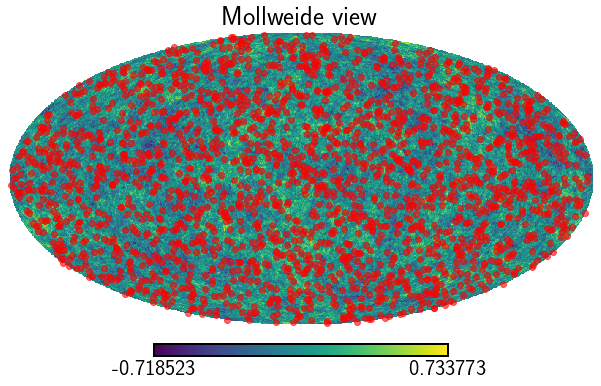

In [8]:
hp.mollview(density)
hp.projscatter(rand_tp[:,0], rand_tp[:,1],
               color = 'red', alpha = 0.6)


In [11]:
nrandoms = 100000
bins = np.logspace(-2.0,-1.0,40)
binx = np.zeros((len(bins),3))
binx[:,0] = np.logspace(-2.0,-1.0,40)
binx[:,1] = np.logspace(-1.6,-0.9,40)
binx[:,2] = np.logspace(-1.6,-0.9,40)
data = compute_cdf(rand_tp, 3, nrandoms, binx)

Text(0, 0.5, 'CDF')

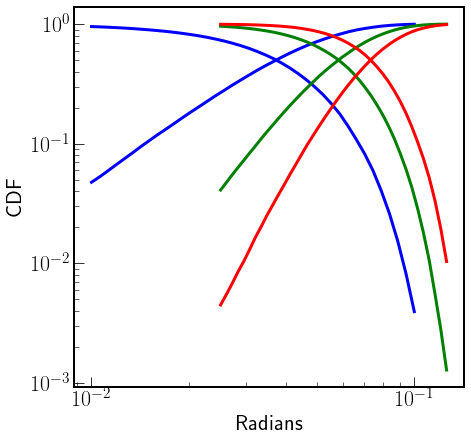

In [14]:
plt.plot(binx[:,0], data[:,0], lw = 3, c = 'blue')
plt.plot(binx[:,0], 1 - data[:,0], lw = 3, c = 'blue')

plt.plot(binx[:,1], data[:,1], lw = 3, c = 'green')
plt.plot(binx[:,1], 1 - data[:,1], lw = 3, c = 'green')

plt.plot(binx[:,2], data[:,2], lw = 3, c = 'red')
plt.plot(binx[:,2], 1 - data[:,2], lw = 3, c = 'red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radians')
plt.ylabel('CDF')